In [1]:
import sys
import os
sys.path.append(f'..{os.sep}')
import mvcomp as mvc
import nibabel as nb
from os.path import join
import glob
import matplotlib.pyplot as plt
import numpy as np

This example illustrates how `mvcomp` can be used to identify voxel to voxel D2 values within a single individual.

# Define data
- here we use the data that we downloaded and generated in Example1 (run Example1 if you have not already done so!)

In [2]:
# indicate what is the subject path where all the feature images are located
# we will use the data in local_extras (check example 1 for more details on how to obtain it)
_mask_path = f'..{os.sep}local_extras{os.sep}sample_MRI'
_subject_path = f"..{os.sep}local_extras{os.sep}sample_MRI{os.sep}001{os.sep}"
P_folders = glob.glob(join(_subject_path,'*nii.gz'))

In [3]:
print(f"We have 3 feature files for this subject, they are\n{P_folders}")

We have 3 feature files for this subject, they are
['../local_extras/sample_MRI/001/T1w.nii.gz', '../local_extras/sample_MRI/001/inv2.nii.gz', '../local_extras/sample_MRI/001/T1map.nii.gz']


# Computing D2
- we limit our computation to a small subset of voxels in the approximate middle of the image for the purposes of this example
  - we use a region of interest in the cerebellar vermis where we can see overlap between brain and CSF
    - most voxels are brain tissue, so the voxels where there is CSF should have large D2 values
  - matrix size grows very quickly, so this may not be practical to conduct voxel-wise in the entire brain in most cases: `(n_vox**3)**2`


In [4]:
# this is v. high res data and requires a large amount of memory to store the entire matrix, therefore we generate a restricted mask
# to be able to compute the matrix
n_vox = 5 #number of voxels in each dimension to compute matrix on

img = nb.load(P_folders[0])
_mask_d = np.zeros(img.shape)
#find the middle of a region of interest, create a cube off of the middle of the image
vox_mid = np.array([112,105,162])
_mask_d[int(vox_mid[0]):int(vox_mid[0])+n_vox,int(vox_mid[1]):int(vox_mid[1])+n_vox,int(vox_mid[2]):int(vox_mid[2])+n_vox] = 1
mask_img = nb.Nifti1Image(_mask_d,affine=img.affine,header=img.header)
mask_fname = os.path.join(_mask_path,'mask_small.nii.gz')
mask_img.to_filename(mask_fname)
print(mask_fname)

# now we run with the restricted mask
result_D2 = mvc.voxel2voxel_dist(subdir= _subject_path,suffix_name_comp = ".nii.gz",mask_f=mask_fname) 

print(result_D2.shape) # Shape will be (number of voxels) x (number of voxels)

../local_extras/sample_MRI/mask_small.nii.gz
Features are :  ['T1map', 'T1w', 'inv2']
(125, 125)


## Visualize the resulting voxelXvoxel D2 matrix

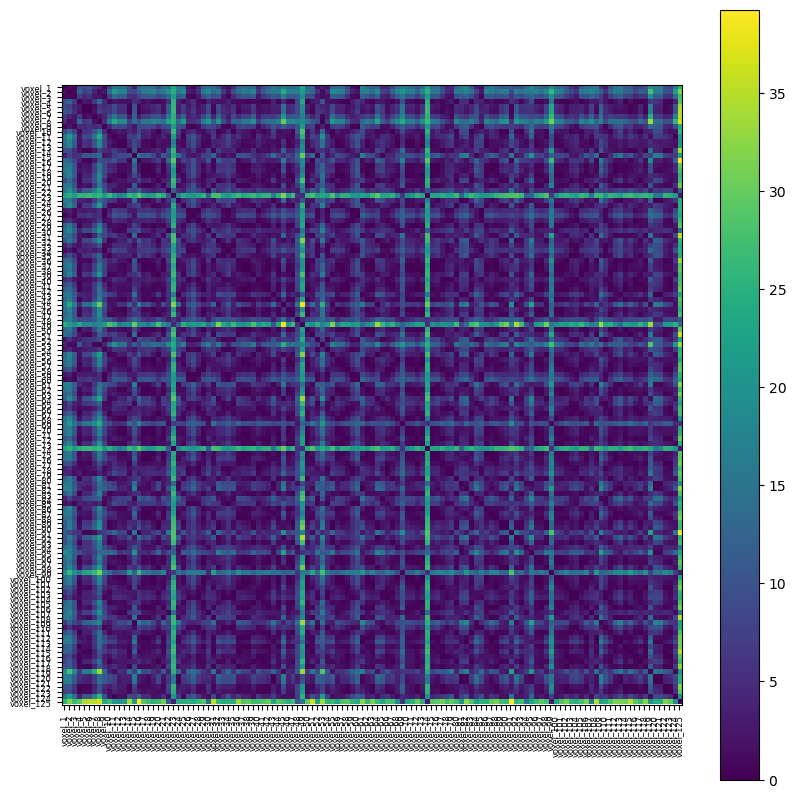

In [5]:
fig = plt.figure(figsize=(10,10))
plt.imshow(result_D2)
vxl_id = [f"voxel_{idx}" for idx in range(1,1+result_D2.shape[0])]
plt.xticks(np.arange(0,result_D2.shape[0]), vxl_id,rotation=90,fontsize=6)
plt.yticks(np.arange(0,result_D2.shape[0]), vxl_id,fontsize=6)

plt.colorbar()
plt.show()


- also show here a simplified per-node value, which can be mapped back to the brain
  - here we simply compute the total D2 for each node as a simple summary metric

Text(0, 0.5, 'Total D2')

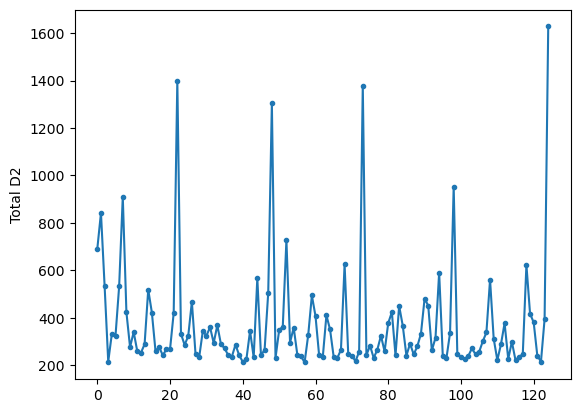

In [6]:
total_D2 = result_D2.sum(axis=0)/2 #compute the total D2 value for each node
plt.plot(total_D2,'.-')
plt.ylabel('Voxel')
plt.ylabel('Total D2')

### Output an image file for subsequent external visualization
- overlay the output D2 map on one of the anatomical images from the subjec (e.g., T1map) for visualization

In [7]:
out_d = np.zeros(img.shape)
out_d[_mask_d.astype(bool)] = total_D2 #project the summary data back into the same location
out_vol = np.reshape(total_D2,(n_vox,n_vox,n_vox))
out_img = nb.Nifti1Image(out_d,affine=img.affine,header=img.header)
out_img.to_filename(os.path.join(_mask_path,'001_vox2vox_D2.nii.gz'))
# vox_mid[0])+n_vox,int(vox_mid[1]):int(vox_mid[1])+n_vox,int(vox_mid[2]):int(vox_mid[2])+n_vox


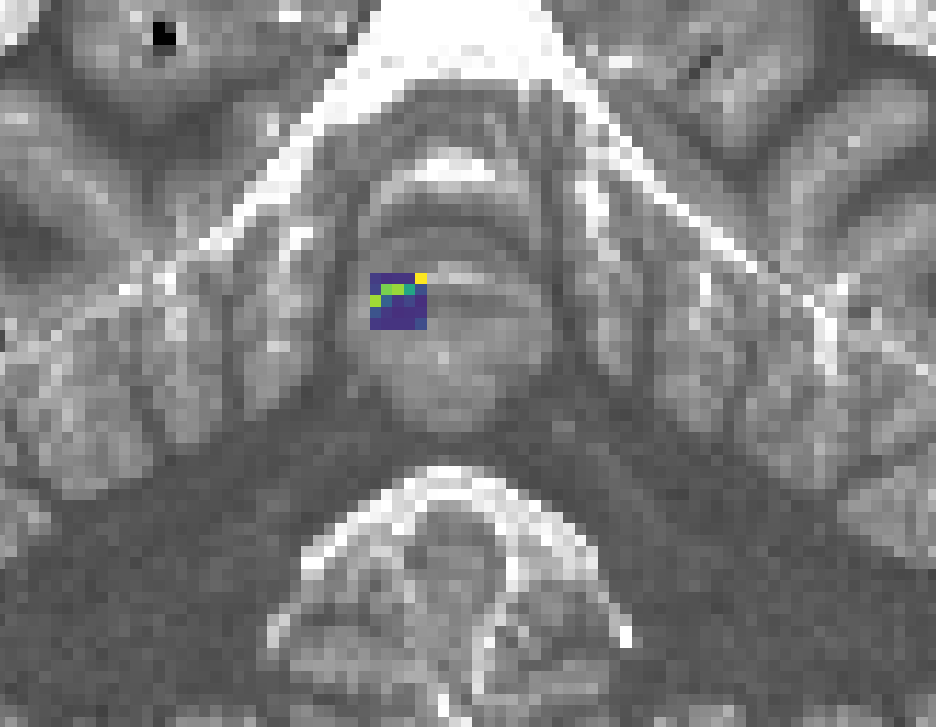

In [8]:
# load a saved version of the generated image for ease of display
from IPython.display import Image
Image(filename='Example3_vox2vox_D2_overlayed_on_T1map.png') 